# Expalining Strategies for Expected Impacts

In this notebook, we present the the different data and plotting to validate our framework.
It is important to notice that:
- the time for finding the strategy is the sum of "time_create_execution_tree", "time_evaluate_cei_execution_tree", and "found_strategy_time";
- the time for explaining the strategy is the sum of "build_strategy_time", "time_explain_strategy", and "strategy_tree_time".

It is important to clarify that during aggregation, we compute and use the mean value. This ensures that the results reflect the average behavior across multiple instances rather than being influenced by outliers or extreme values.
Moreover, here multiple plot that have not been inserted into the article can be found.

In [1]:
from pony.orm import Database
import pandas as pd
import numpy as np
columns = [
    "nested",
    "indep",
    "w",
    "variant",
    "num_impacts",
    "choice_distribution",
    "generation_mode",
    "duration_interval_min",
    "duration_interval_max",
    "vts",
    "vte",
    "time_create_execution_tree",
    "time_evaluate_cei_execution_tree",
    "found_strategy_time",
    "build_strategy_time",
    "time_explain_strategy",
    "strategy_tree_time",
    "initial_bounds",
    "final_bounds",
    "error"
]
# database binnding for our experiments
db = Database()
db.bind(provider='sqlite', filename='/media/DATA/emanuelechini/aamas2025/validation/results/benchmarks_our.sqlite', create_db=False) # if not working, put the full path for benchmarks_our.sqlite
# Getting the data from the DB
data = pd.DataFrame(db.execute("SELECT * FROM experiments"), columns = columns)

In [2]:
# printing the data
data

,nested,indep,w,variant,num_impacts,choice_distribution,generation_mode,duration_interval_min,duration_interval_max,vts,vte,time_create_execution_tree,time_evaluate_cei_execution_tree,found_strategy_time,build_strategy_time,time_explain_strategy,strategy_tree_time,initial_bounds,final_bounds,error
0,1,2,0,1,1,0.1,random,1,10,2025-03-12T16:23:26.276232,2025-03-12T16:23:26.299918,4.246,0.010,0.210,0.003,0.004,2.466,[5.083605043658887],[5.083605043658887],
1,1,2,1,1,1,0.1,bagging_divide,1,10,2025-03-12T16:23:26.304162,2025-03-12T16:23:26.318870,4.038,0.011,0.163,0.004,0.003,2.401,[0.6431429636989907],[0.6431429636989907],
2,1,2,2,1,1,0.1,bagging_remove,1,10,2025-03-12T16:23:26.320773,2025-03-12T16:23:26.333716,4.179,0.010,0.165,0.002,0.002,2.432,[5.749123073413825],[5.749123073413825],
3,1,2,3,1,1,0.1,bagging_remove_divide,1,10,2025-03-12T16:23:26.335869,2025-03-12T16:23:26.349301,3.997,0.011,0.167,0.002,0.002,2.428,[0.5444791815992785],[0.5444791815992785],
4,1,2,4,1,1,0.1,bagging_remove_reverse,1,10,2025-03-12T16:23:26.351132,2025-03-12T16:23:26.364351,4.152,0.012,0.105,0.002,0.002,2.904,[0.0],[0.0],
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92891,3,4,1091,3,1,0.2,bagging_remove_reverse_divide,1,10,2025-03-26T16:09:04.631790,2025-03-26T16:09:05.553335,367.459,0.112,0.137,0.003,0.004,140.877,[0.0],[0.0],
92892,3,4,1092,3,1,0.3,random,1,10,2025-03-26T16:09:05.563455,2025-03-26T16:09:07.873175,379.706,0.150,155.364,1295.551,0.032,59.892,[10.040733141669916],[9.217079251142305],
92893,3,4,1093,3,1,0.3,bagging_divide,1,10,2025-03-26T16:09:07.876170,2025-03-26T16:09:10.361483,357.135,0.152,18.672,1230.798,0.040,340.362,[0.8748356509623922],[0.8748356509623922],
92894,3,4,1094,3,1,0.3,bagging_remove,1,10,2025-03-26T16:09:10.372187,2025-03-26T16:09:14.892613,443.875,0.156,3.023,3781.610,0.048,54.190,[7.20132523941227],[7.20132523941227],


## Plotting

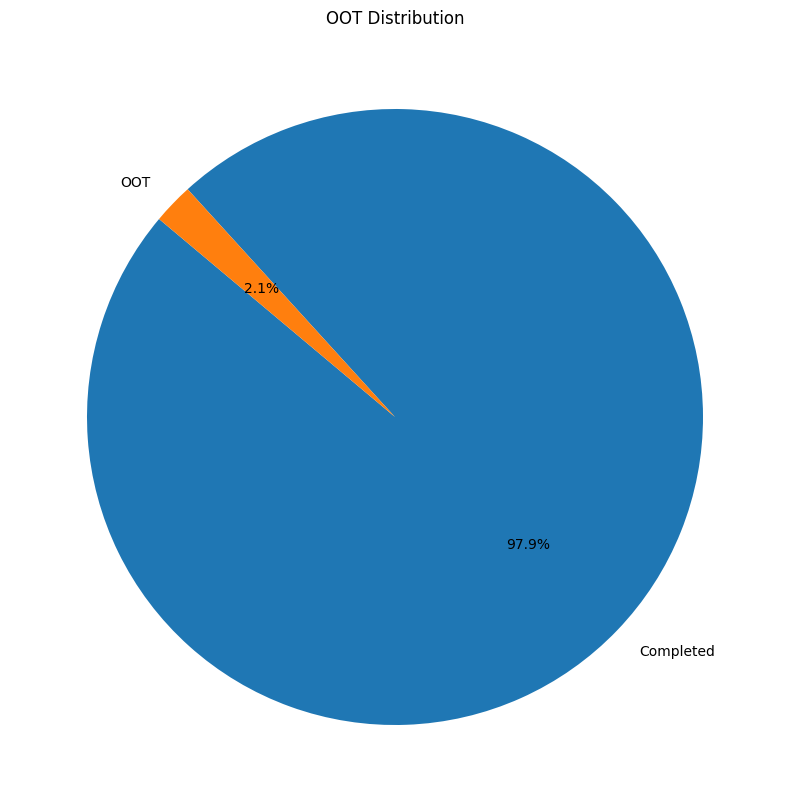

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
# Sample data transformation
df = data[['error']].copy()
df['OOT'] = df['error'].isna()
df_grouped = df['OOT'].value_counts()

# Create the pie chart
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(df_grouped, labels=df_grouped.index.map({True: "OOT", False: "Completed"}), 
                                   autopct='%1.1f%%', startangle=140,)

plt.title("OOT Distribution")
plt.show()


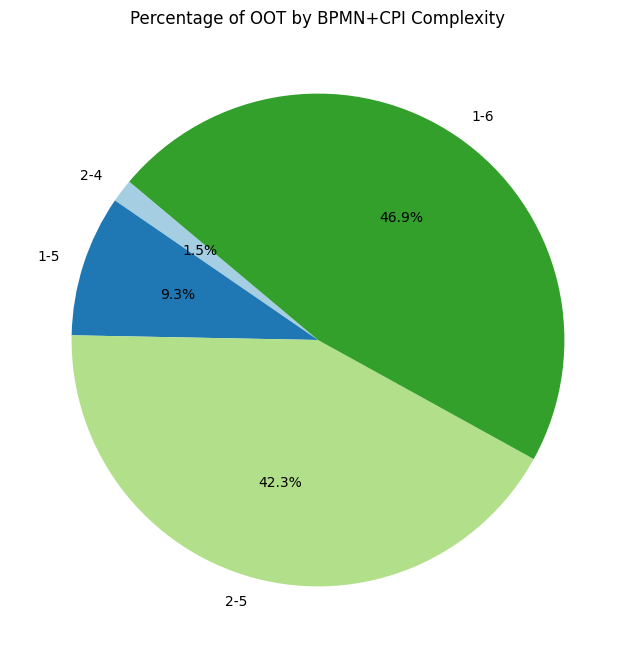

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
df = data[~((data['nested'] == 3) & (data['indep'] == 4))]
# Count total occurrences of each (nested, indep) combination
total_counts = df.groupby(['nested', 'indep']).size().reset_index(name='total_count')

# Count None (or NaN) values in the 'error' column for each (nested, indep)
none_counts = df['error'].isna().groupby([df['nested'], df['indep']]).sum().reset_index(name='none_count')

# Merge the counts
merged_counts = pd.merge(total_counts, none_counts, on=['nested', 'indep'])

# Compute the percentage of None values
merged_counts['none_percentage'] = (merged_counts['none_count'] / merged_counts['total_count']) * 100

# Compute the sum of nested + indep for ordering
merged_counts['nested_indep_sum'] = merged_counts['nested'] + merged_counts['indep']

# Sort by the sum of (nested + indep)
merged_counts = merged_counts.sort_values(by='nested_indep_sum')

merged_counts = merged_counts.loc[~(merged_counts['none_percentage']==0)]

# Plot
# plt.figure(figsize=(12, 6))
# plt.bar(merged_counts[['nested', 'indep']].astype(str).agg('-'.join, axis=1), merged_counts['none_percentage'])

# plt.xticks(rotation=45, ha="right")
# plt.xlabel("Nested → Indep ")
# plt.ylabel("Percentage of OOT (%)")
# plt.title("Percentage of OOT")
plt.figure(figsize=(8, 8))
labels = merged_counts[['nested', 'indep']].astype(str).agg('-'.join, axis=1)
sizes = merged_counts['none_percentage']
colors = plt.cm.Paired.colors

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Percentage of OOT by BPMN+CPI Complexity")
# plt.ylim(0, max(merged_counts['none_percentage'])*1.05)  # Ensure the y-axis goes from 0 to 100%
# 
SMALL_SIZE = 24
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*1.5)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)
# Show the plot
plt.show()

In [5]:
df

,nested,indep,w,variant,num_impacts,choice_distribution,generation_mode,duration_interval_min,duration_interval_max,vts,vte,time_create_execution_tree,time_evaluate_cei_execution_tree,found_strategy_time,build_strategy_time,time_explain_strategy,strategy_tree_time,initial_bounds,final_bounds,error
0,1,2,0,1,1,0.1,random,1,10,2025-03-12T16:23:26.276232,2025-03-12T16:23:26.299918,4.246,0.010,0.210,0.003,0.004,2.466,[5.083605043658887],[5.083605043658887],
1,1,2,1,1,1,0.1,bagging_divide,1,10,2025-03-12T16:23:26.304162,2025-03-12T16:23:26.318870,4.038,0.011,0.163,0.004,0.003,2.401,[0.6431429636989907],[0.6431429636989907],
2,1,2,2,1,1,0.1,bagging_remove,1,10,2025-03-12T16:23:26.320773,2025-03-12T16:23:26.333716,4.179,0.010,0.165,0.002,0.002,2.432,[5.749123073413825],[5.749123073413825],
3,1,2,3,1,1,0.1,bagging_remove_divide,1,10,2025-03-12T16:23:26.335869,2025-03-12T16:23:26.349301,3.997,0.011,0.167,0.002,0.002,2.428,[0.5444791815992785],[0.5444791815992785],
4,1,2,4,1,1,0.1,bagging_remove_reverse,1,10,2025-03-12T16:23:26.351132,2025-03-12T16:23:26.364351,4.152,0.012,0.105,0.002,0.002,2.904,[0.0],[0.0],
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92628,5,1,5395,10,10,0.9,bagging_divide,1,10,2025-03-26T15:06:04.573786,2025-03-26T15:06:04.661277,16.508,0.060,17.490,33.472,0.024,0.738,"[0.27812280660204813, 0.9194289631965689, 1.19...","[0.27812280660204813, 0.9194289631965689, 1.19...",
92629,5,1,5396,10,10,0.9,bagging_remove,1,10,2025-03-26T15:06:04.663249,2025-03-26T15:06:04.756443,17.246,0.060,17.928,37.180,0.021,0.672,"[1.8462446018032903, 1.9124884941882025, 2.287...","[1.8462446018032903, 1.9124884941882025, 2.287...",
92630,5,1,5397,10,10,0.9,bagging_remove_divide,1,10,2025-03-26T15:06:04.759024,2025-03-26T15:06:04.981957,98.763,0.055,17.486,80.811,0.018,5.795,"[0.13843794495199782, 0.14449689672377475, 0.1...","[0.13843794495199782, 0.14449689672377475, 0.1...",
92631,5,1,5398,10,10,0.9,bagging_remove_reverse,1,10,2025-03-26T15:06:04.984090,2025-03-26T15:06:05.154494,17.404,0.053,22.522,109.201,0.016,0.814,"[0.48868617621839416, 0.08993226162232226, 1.8...","[0.48868617621839416, 0.08993226162232226, 1.8...",


/tmp/ipykernel_918776/3841101975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_create_strategy'] = data['time_create_execution_tree'] + data['time_evaluate_cei_execution_tree'] + data['found_strategy_time']
/tmp/ipykernel_918776/3841101975.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_explain_strategy'] = data['build_strategy_time'] + data['time_explain_strategy'] + data['strategy_tree_time']


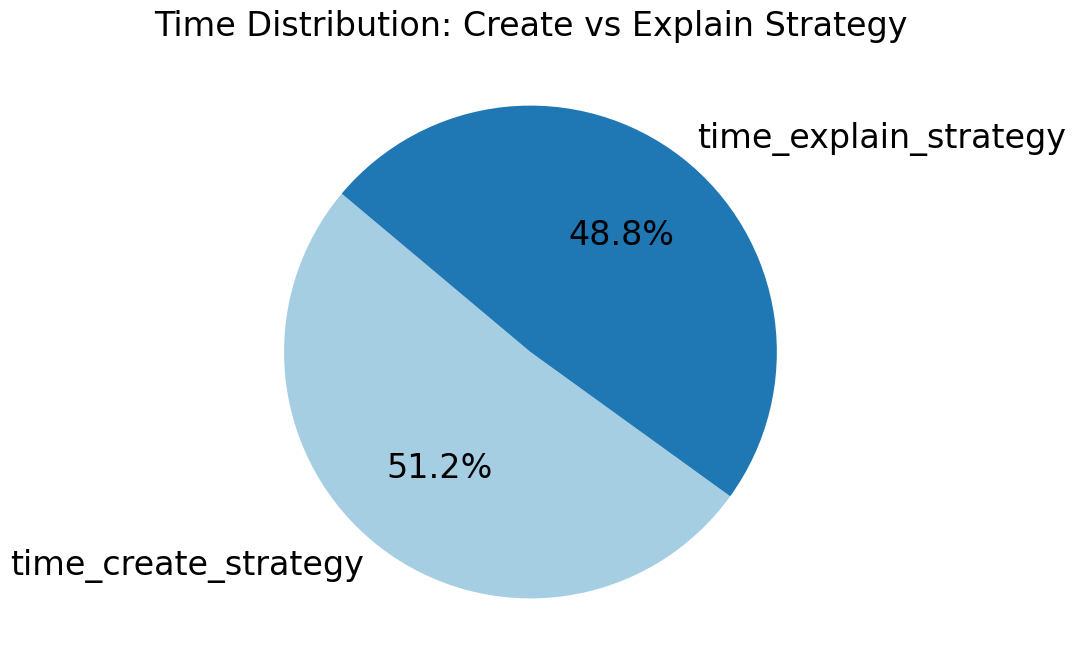

In [6]:
import matplotlib.pyplot as plt
df['time_create_strategy'] = data['time_create_execution_tree'] + data['time_evaluate_cei_execution_tree'] + data['found_strategy_time']
df['time_explain_strategy'] = data['build_strategy_time'] + data['time_explain_strategy'] + data['strategy_tree_time']

# Only plot the distribution between create and explain strategy
time_sums = df[['time_create_strategy', 'time_explain_strategy']].sum()

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    time_sums, labels=time_sums.index, autopct='%1.1f%%',
    startangle=140, colors=plt.cm.Paired.colors
    )
plt.title("Time Distribution: Create vs Explain Strategy")
plt.show()

/tmp/ipykernel_918776/2020109469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_create_strategy'] = df['time_create_execution_tree'] + df['time_evaluate_cei_execution_tree'] + df['found_strategy_time']
/tmp/ipykernel_918776/2020109469.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_explain_strategy'] = df['build_strategy_time'] + df['time_explain_strategy'] + df['strategy_tree_time']


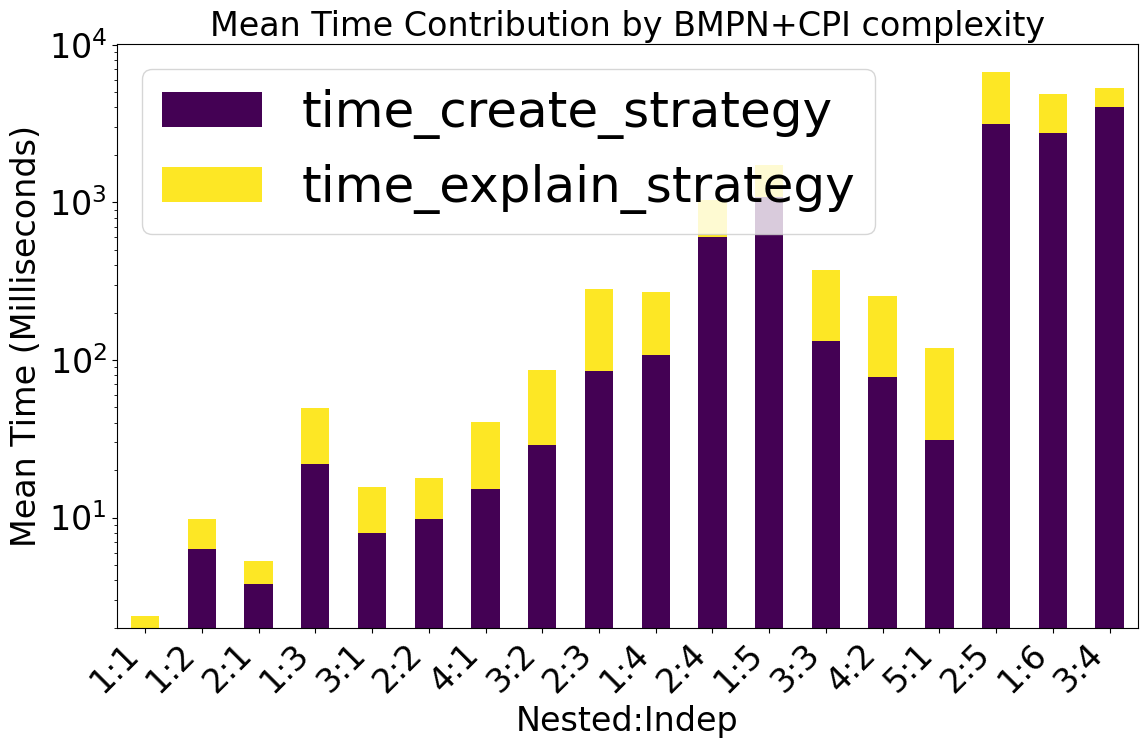

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample dataframe transformation (you should already have this)
df = data[['nested', "indep",  'time_create_execution_tree', 'time_evaluate_cei_execution_tree', 'found_strategy_time',
           'build_strategy_time', 'time_explain_strategy', 'strategy_tree_time']]

# Create new time columns
df['time_create_strategy'] = df['time_create_execution_tree'] + df['time_evaluate_cei_execution_tree'] + df['found_strategy_time']
df['time_explain_strategy'] = df['build_strategy_time'] + df['time_explain_strategy'] + df['strategy_tree_time']

# Drop unnecessary columns
df = df.drop(columns=['time_evaluate_cei_execution_tree', 'build_strategy_time', 
                      'time_create_execution_tree', 'time_evaluate_cei_execution_tree', 
                      'found_strategy_time', 'build_strategy_time', 'strategy_tree_time'])

# Compute nested_indep_sum for ordering
df['nested_indep_sum'] = df['nested'] + df['indep']

# Create a 'nested:indep' column for clarity
df['nested_indep'] = df['nested'].astype(str) + ":" + df['indep'].astype(str)

# Group by 'nested_indep' and compute the sum of the time contributions
df_grouped = df.groupby(['nested_indep', 'nested_indep_sum'])[['time_create_strategy', 'time_explain_strategy']].mean().reset_index()

# Sort by 'nested_indep_sum'
df_grouped = df_grouped.sort_values(by='nested_indep_sum')

# Plot bar graph for each nested:indep combination
fig, ax = plt.subplots(figsize=(12,8))

# Plot stacked bar chart
df_grouped.set_index('nested_indep')[['time_create_strategy', 'time_explain_strategy']].plot(kind='bar', stacked=True, ax=ax, colormap="viridis")

# Labels and title
ax.set_xlabel("Nested:Indep")
ax.set_ylabel("Mean Time (Milliseconds)")
ax.set_title("Mean Time Contribution by BMPN+CPI complexity")
plt.yscale('log')
# Show the plot
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
SMALL_SIZE = 24
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE/1.5)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)
plt.show()


## Heatmaps

/tmp/ipykernel_918776/3313401946.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['strategy_tree_time']  = data[[ 'time_create_execution_tree', 'time_evaluate_cei_execution_tree', 'found_strategy_time',


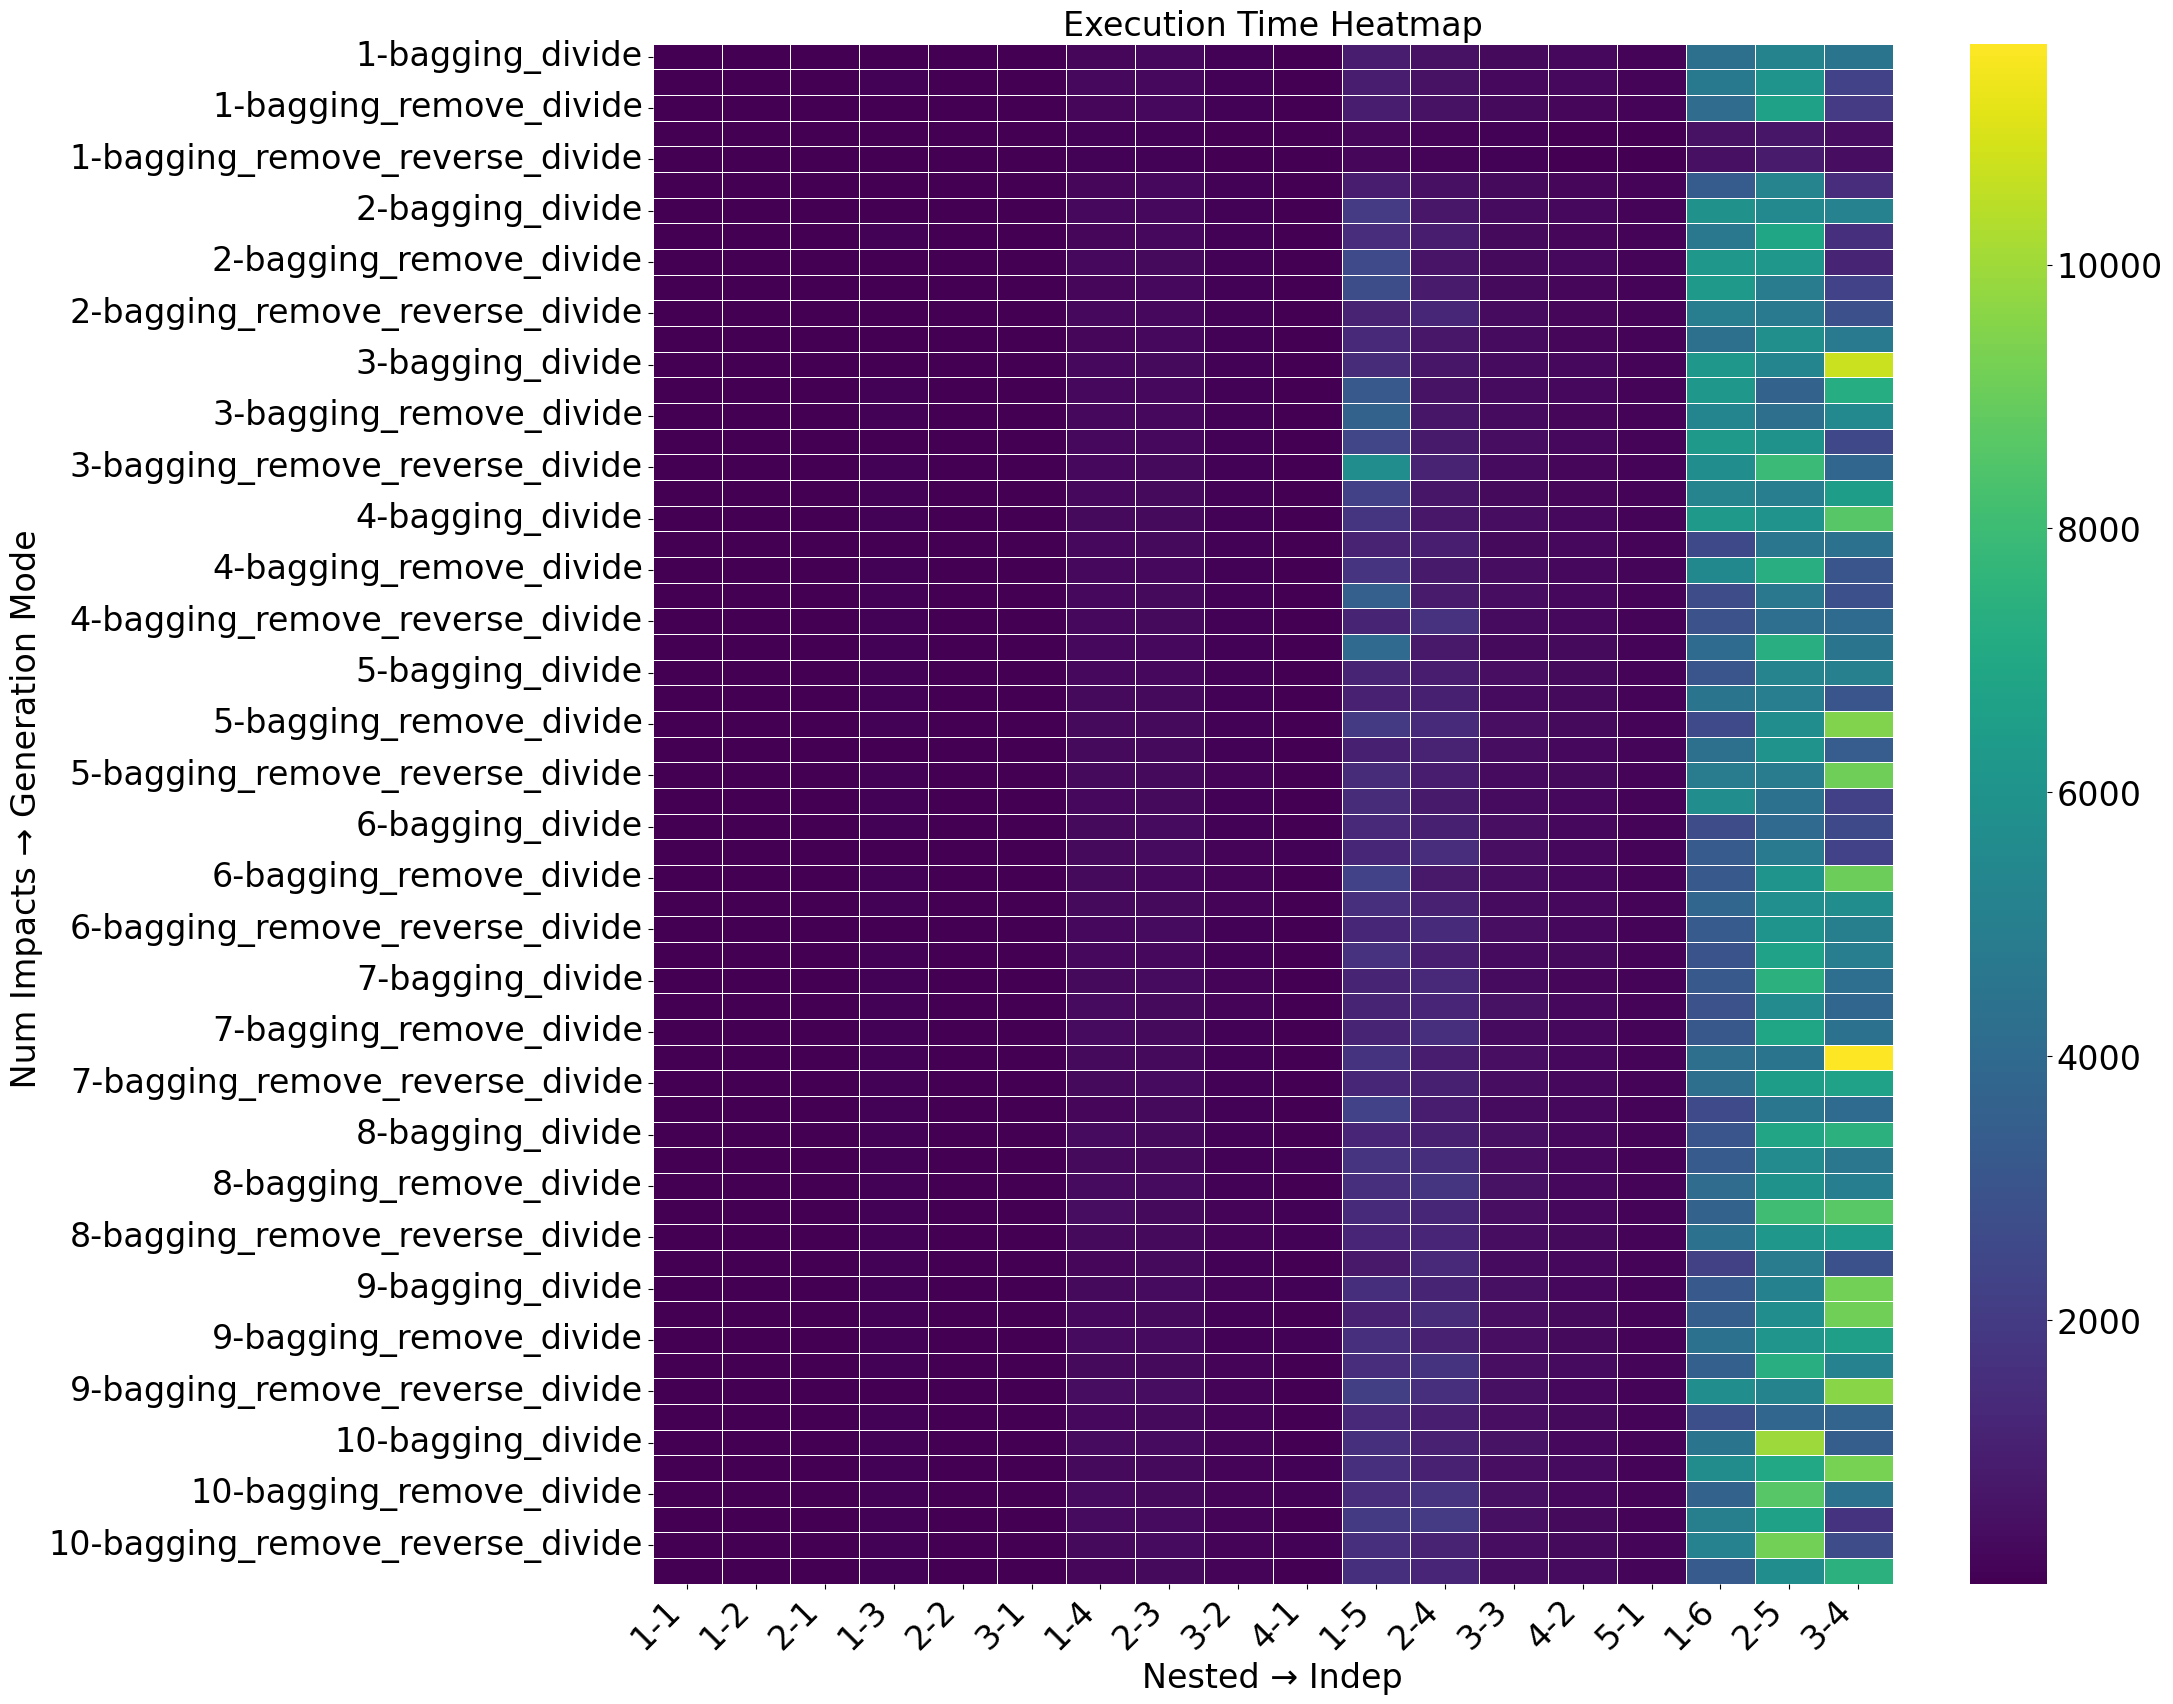

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
df = data[['nested', 'generation_mode', "indep", "num_impacts"]]

df['strategy_tree_time']  = data[[ 'time_create_execution_tree', 'time_evaluate_cei_execution_tree', 'found_strategy_time',
'build_strategy_time', 'time_explain_strategy', 'strategy_tree_time']].copy().sum(axis=1)
# print(df_t.head())

# Aggregate duplicate combinations by taking the mean
df_grouped = df.groupby(['generation_mode', 'num_impacts', 'nested', 'indep']).strategy_tree_time.mean().reset_index()

# Compute the sum of nested + indep for ordering
df_grouped['nested_indep_sum'] = df_grouped['nested'] + df_grouped['indep']

# Pivot table with multi-level x-axis (nested, indep) and y-axis (generation_mode, num_impacts)
heatmap_data = df_grouped.pivot(index=['num_impacts', 'generation_mode'], columns=['nested', 'indep'], values='strategy_tree_time')

# Order the columns based on the sum of (nested + indep)
sorted_columns = sorted(heatmap_data.columns, key=lambda x: x[0] + x[1])  # Sorting by sum of (nested, indep)

# Reorder the pivot table columns
heatmap_data = heatmap_data[sorted_columns]

# Plot heatmap
plt.figure(figsize=(20, 20))
ax = sns.heatmap(heatmap_data, cmap="viridis", linewidth=0.5, annot=False, fmt=".2f")

# Labels and title
plt.xlabel("Nested → Indep")
plt.ylabel(" Num Impacts → Generation Mode")
plt.title("Execution Time Heatmap")

# Adjust x-axis and y-axis formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for readability
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Keep y labels readable
plt.show()

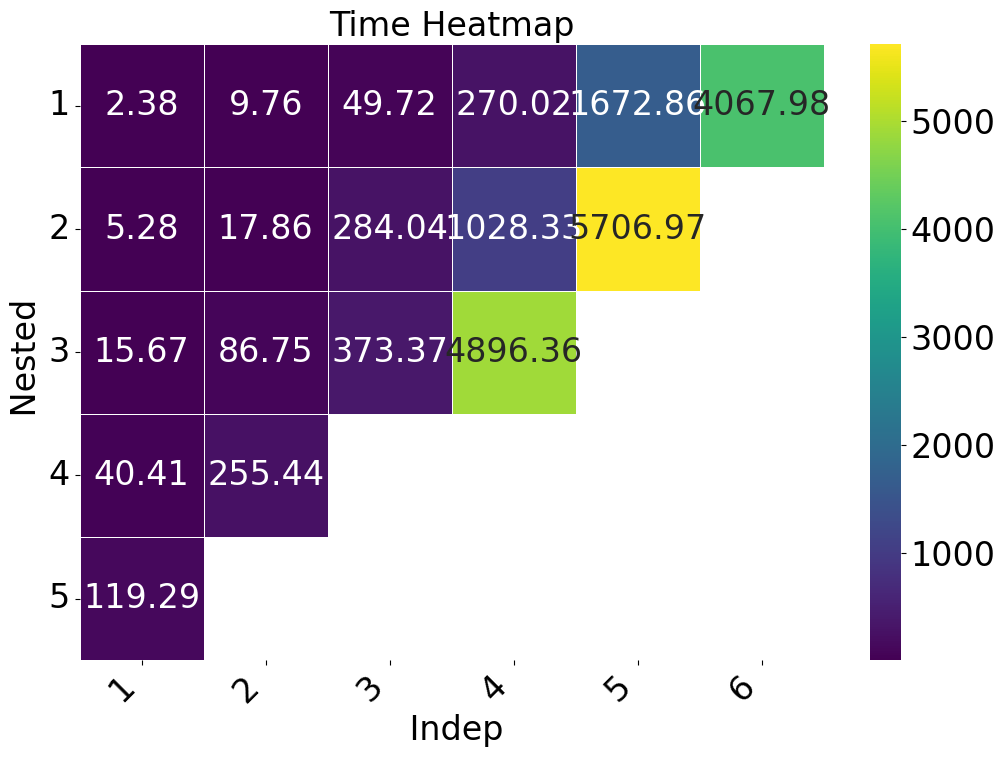

In [9]:
df_grouped = df.groupby(['nested', 'indep']).strategy_tree_time.mean().reset_index()

heatmap_data = df_grouped.pivot(index=['nested'], columns=[ 'indep'], values='strategy_tree_time')

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, cmap="viridis", linewidth=0.5, annot=True, fmt=".2f")

# Labels and title
plt.xlabel(" Indep")
plt.ylabel(" Nested  ")
plt.title("Time Heatmap")

# Adjust x-axis and y-axis formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for readability
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  
# Show the plot
plt.show()

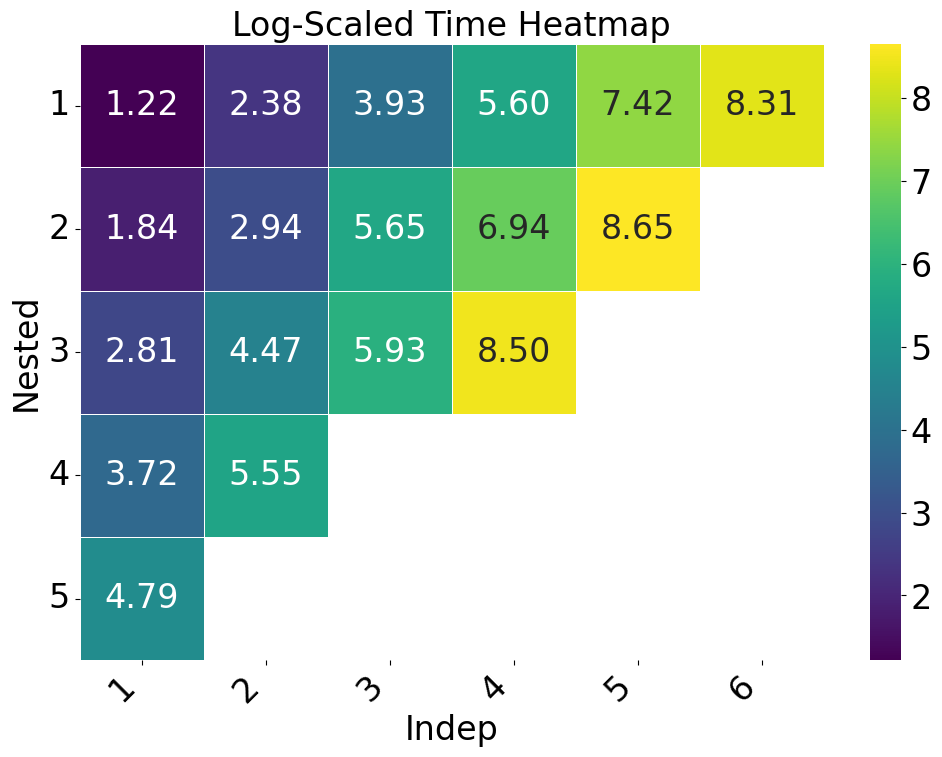

In [10]:
df_grouped['strategy_tree_time_log'] = np.log1p(df_grouped['strategy_tree_time'])

# Pivot table for heatmap
heatmap_data = df_grouped.pivot(index='nested', columns='indep', values='strategy_tree_time_log')

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, cmap="viridis", linewidth=0.5, annot=True, fmt=".2f")

# Labels and title
plt.xlabel("Indep")
plt.ylabel("Nested")
plt.title("Log-Scaled Time Heatmap")

# Adjust x-axis and y-axis formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

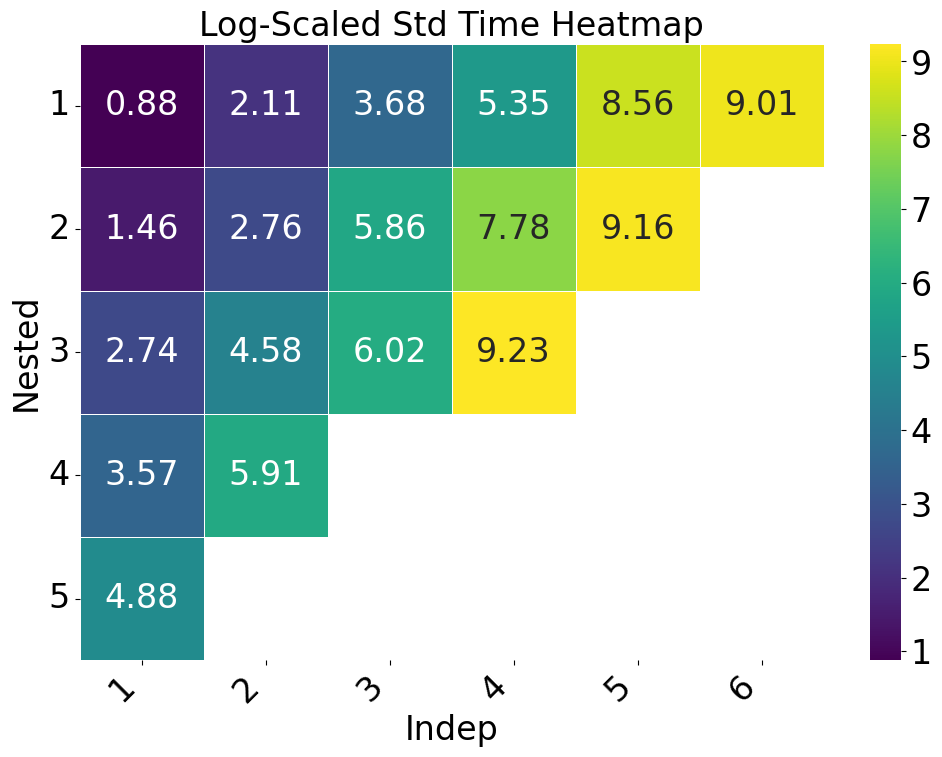

In [11]:
# Grouping by 'nested' and 'indep', calculating mean & std
df_grouped = df.groupby(['nested', 'indep']).strategy_tree_time.agg(['mean', 'std']).reset_index()

# Apply log transformation to avoid issues with zero values
df_grouped['strategy_tree_time_log_mean'] = np.log1p(df_grouped['mean'])
df_grouped['strategy_tree_time_log_std'] = np.log1p(df_grouped['std'])  # Log of std as well

# Pivot tables for heatmaps
heatmap_data_mean = df_grouped.pivot(index='nested', columns='indep', values='strategy_tree_time_log_mean')
heatmap_data_std = df_grouped.pivot(index='nested', columns='indep', values='strategy_tree_time_log_std')


# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data_std, cmap="viridis", linewidth=0.5, annot=True, fmt=".2f")

# Labels and title
plt.xlabel("Indep")
plt.ylabel("Nested")
plt.title("Log-Scaled Std Time Heatmap")

# Adjust x-axis and y-axis formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
# Show the plot
plt.show()

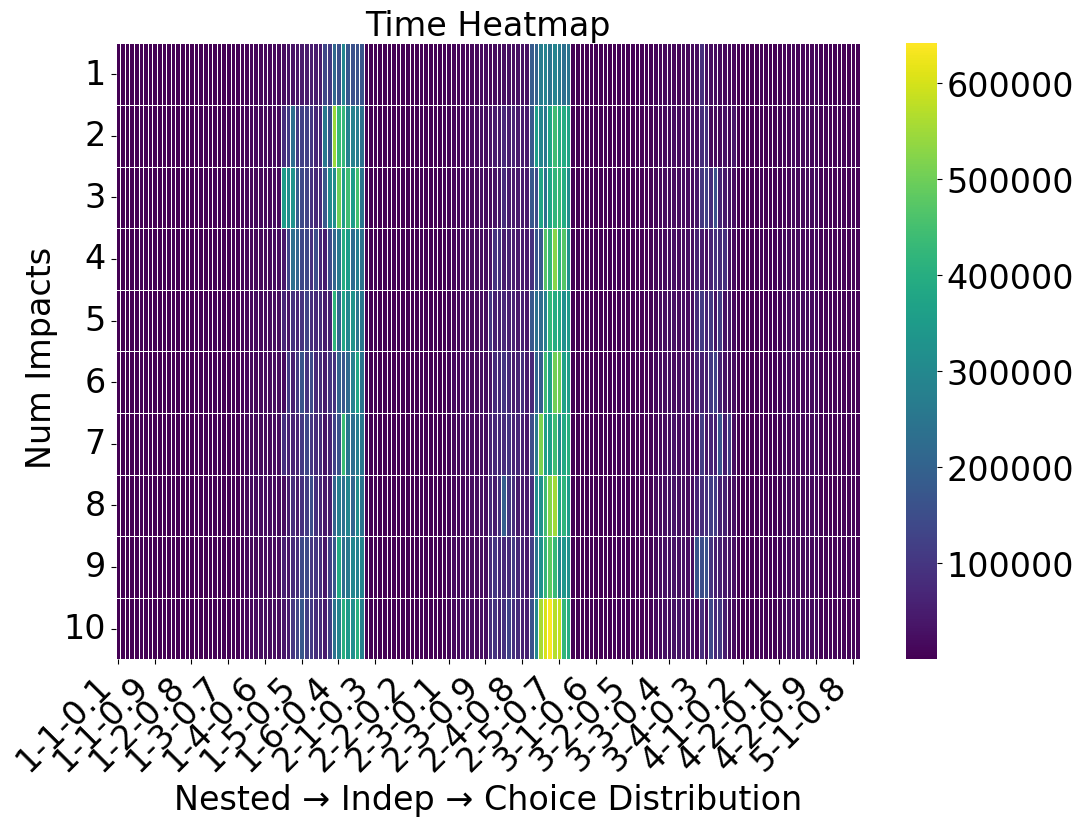

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sum the time-related columns per row
df_times = data[['time_create_execution_tree', 'time_evaluate_cei_execution_tree', 
                 'found_strategy_time', 'build_strategy_time', 
                 'time_explain_strategy', 'strategy_tree_time']].sum(axis=1)

# Extract relevant columns and assign the summed times correctly
df = data[['nested', "choice_distribution","indep", "num_impacts"]].copy()
df['strategy_tree_time'] = df_times  # Correctly assign summed times per row

# Aggregate duplicate combinations by summing their times
df_grouped = df.groupby([ 'num_impacts', 'nested', 'indep',"choice_distribution"]).strategy_tree_time.sum().reset_index()

# Pivot table with a multi-level x-axis: (nested, indep) and multi-level y-axis: (generation_mode, num_impacts)
heatmap_data = df_grouped.pivot(index=['num_impacts'], columns=['nested', 'indep', "choice_distribution",], values='strategy_tree_time')

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, cmap="viridis", linewidth=0.5, annot=False, fmt=".2f")

# Labels and title
plt.xlabel("Nested → Indep → Choice Distribution")
plt.ylabel("Num Impacts ")
plt.title("Time Heatmap")

# Adjust x-axis and y-axis formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for readability
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Keep y labels readable
plt.savefig('times_heatmap_no_generation_methods.svg', format='svg')
# Show the plot
plt.show()


## Time Heatmap of BPMN+CPI Complexity ("Nested → Indep → Choice Distribution") vs Impacts ("Num Impacts → Generation Mode ")

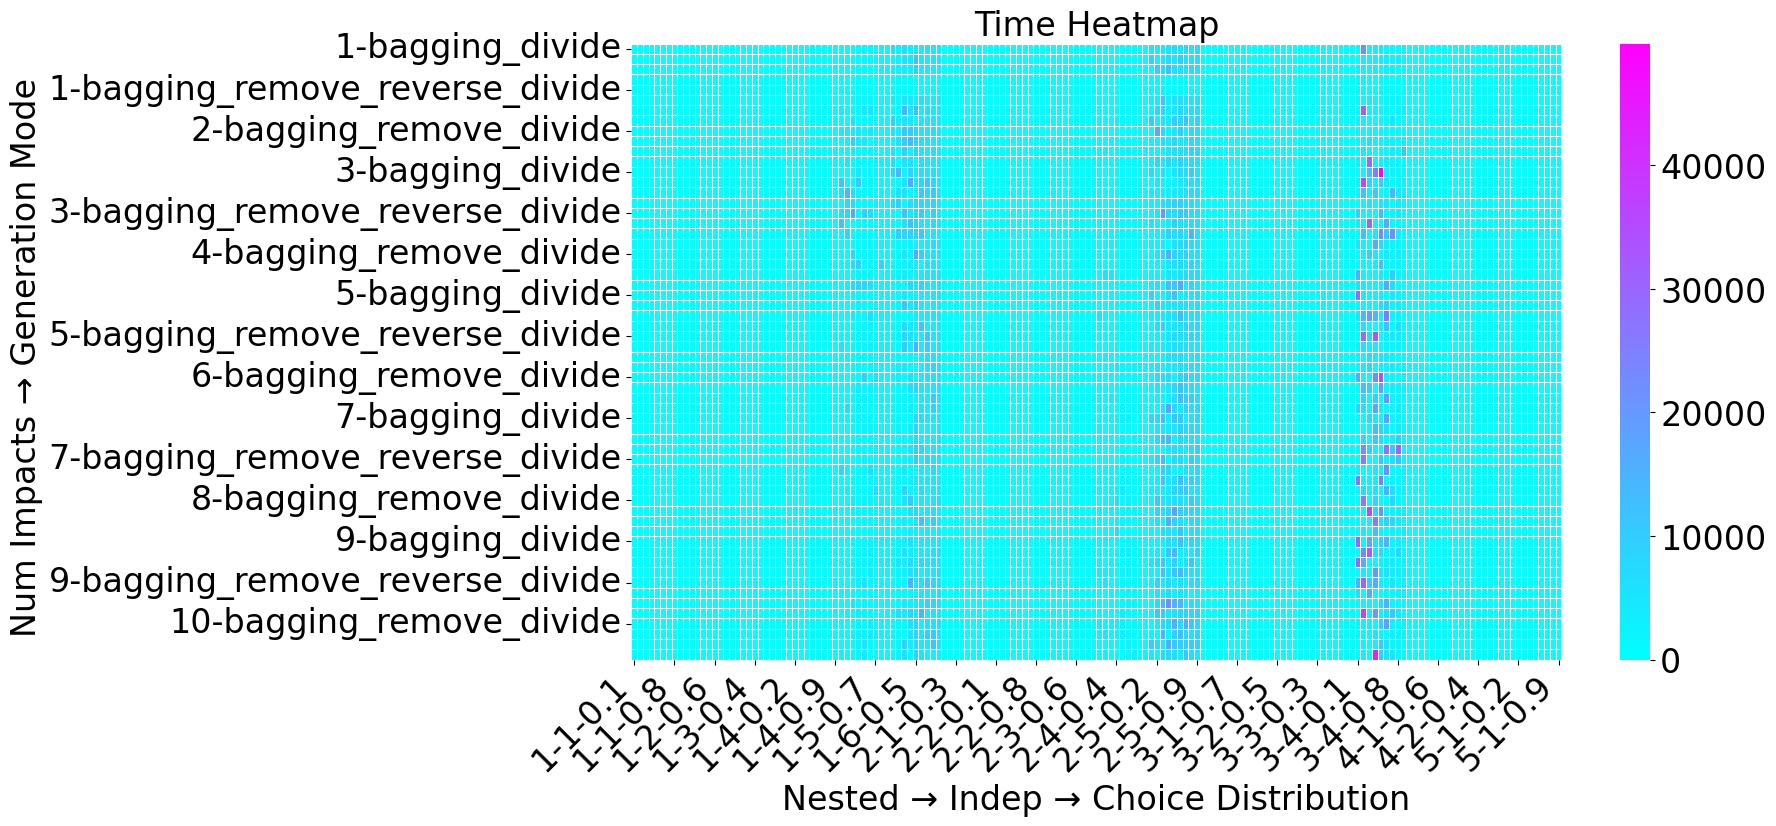

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# # Sum the time-related columns per row
df_times = data[['time_create_execution_tree', 'time_evaluate_cei_execution_tree', 
                 'found_strategy_time', 'build_strategy_time', 
                 'time_explain_strategy', 'strategy_tree_time']].sum(axis=1)

# Extract relevant columns and assign the summed times correctly
df = data[['nested', 'generation_mode', "choice_distribution","indep", "num_impacts",
           # 'time_create_execution_tree', 'time_evaluate_cei_execution_tree', 
           #       'found_strategy_time', 'build_strategy_time', 
           #       'time_explain_strategy', 'strategy_tree_time'
          ]].copy()
df['strategy_tree_time'] = df_times  # Correctly assign summed times per row

# Aggregate duplicate combinations by summing their times
df_grouped = df.groupby(['generation_mode', 'num_impacts', 'nested', 'indep',"choice_distribution"]).strategy_tree_time.mean().reset_index()

# Pivot table with a multi-level x-axis: (nested, indep) and multi-level y-axis: (generation_mode, num_impacts)
heatmap_data = df_grouped.pivot(index=['num_impacts', 'generation_mode'], columns=['nested', 'indep', "choice_distribution",], values='strategy_tree_time')
# heatmap_data = heatmap_data.fillna(0)
# print(heatmap_data.values.isna().any())
# Plot heatmap
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, cmap="cool", linewidth=0.5, annot=False, fmt=".2f")

# Labels and title
plt.xlabel("Nested → Indep → Choice Distribution")
plt.ylabel("Num Impacts → Generation Mode ")
plt.title("Time Heatmap")

# Adjust x-axis and y-axis formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for readability
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Keep y labels readable
# Show the plot
plt.show()

### Heatmap Detailed

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevantdata
df = data[['nested', 'generation_mode', "indep", "num_impacts"]]

df['strategy_tree_time']  = data[[ 'time_create_execution_tree', 'time_evaluate_cei_execution_tree', 'found_strategy_time',
'build_strategy_time', 'time_explain_strategy', 'strategy_tree_time']].copy().sum(axis=1)


/tmp/ipykernel_918776/966763281.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['strategy_tree_time']  = data[[ 'time_create_execution_tree', 'time_evaluate_cei_execution_tree', 'found_strategy_time',


In [15]:
# Aggregate duplicate combinations by taking the mean
df_grouped = df.groupby(['generation_mode', 'num_impacts', 'nested', 'indep']).strategy_tree_time.mean().reset_index()

# Compute the sum of nested + indep for ordering
df_grouped['nested_indep_sum'] = df_grouped['nested'] + df_grouped['indep']

# Filter by complexity & impacts


df_grouped = df_grouped[
    # nested_indep_sum is MNXN + MIX 2-20
    (df_grouped['nested_indep_sum']>=6) & 
    # dimension of the impact vector 1-10
    (df_grouped['num_impacts']>=6)
    
]

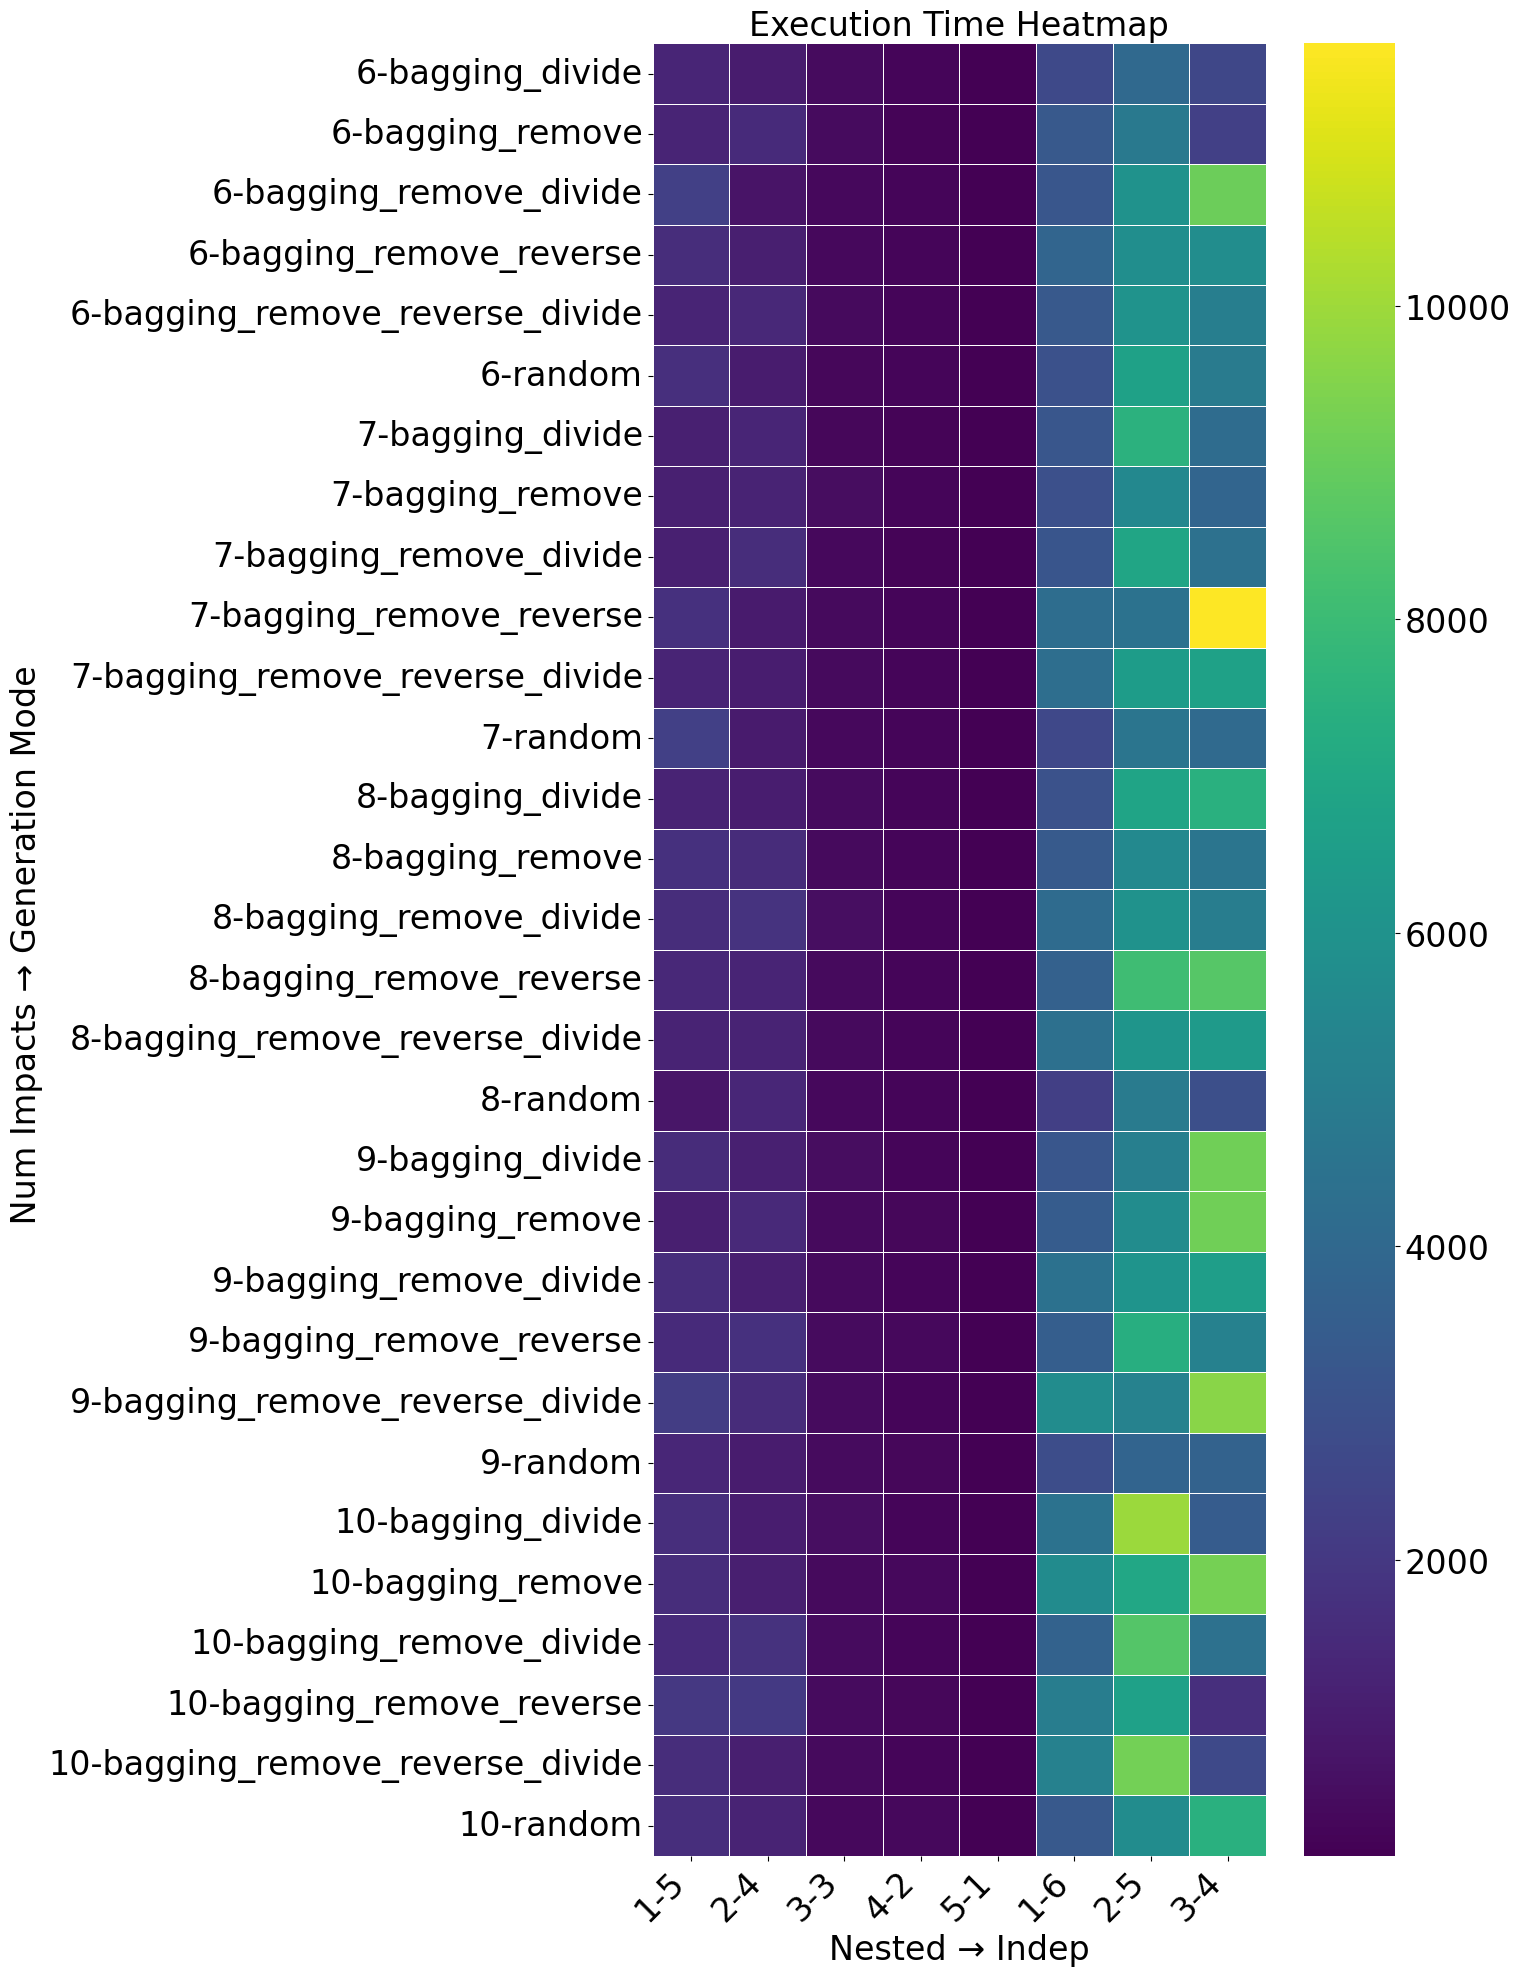

In [16]:

heatmap_data = df_grouped.pivot(index=['num_impacts', 'generation_mode'], columns=['nested', 'indep'], values='strategy_tree_time')

# Order the columns based on the sum of (nested + indep)
sorted_columns = sorted(heatmap_data.columns, key=lambda x: x[0] + x[1])  # Sorting by sum of (nested, indep)

# Reorder the pivot table columns
heatmap_data = heatmap_data[sorted_columns]

# Plot heatmap
plt.figure(figsize=(15, 20))
# If you want to plot the data put annot=True, False otherwise
ax = sns.heatmap(heatmap_data, cmap="viridis", linewidth=0.5, annot=False, fmt=".2f")

# Labels and title
plt.xlabel("Nested → Indep")
plt.ylabel(" Num Impacts → Generation Mode")
plt.title("Execution Time Heatmap")
plt.tight_layout(rect=[0, 0, 1, 1])
# Adjust x-axis and y-axis formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for readability
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Keep y labels readable
SMALL_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*1.5)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)
# Show the plot
plt.show()


## Execution Time Heatmap: BPMN+CPI Complexity ("Nested:Indep") vs. Choice Distribution

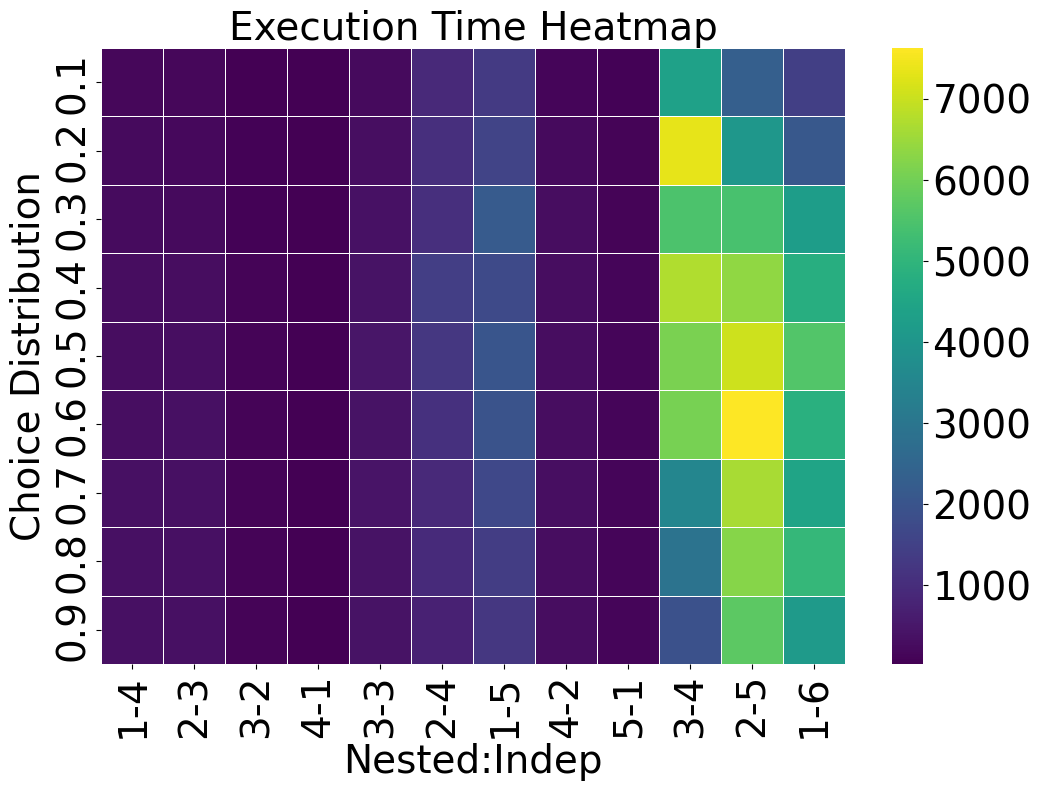

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute summed times across all relevant columns
df_times = data[['time_create_execution_tree', 'time_evaluate_cei_execution_tree', 
                 'found_strategy_time', 'build_strategy_time', 
                 'time_explain_strategy', 'strategy_tree_time']].sum(axis=1)

# Extract relevant columns
df = data[['nested', "choice_distribution", "indep", "num_impacts"]].copy()

# Assign the computed strategy tree time
df['strategy_tree_time'] = df_times

# Compute the sum of nested + indep for ordering
df['nested_indep_sum'] = df['nested'] + df['indep']

# Create a 'nested:indep' column
df['nested_indep'] = df['nested'].astype(str) + "-" + df['indep'].astype(str)

# Aggregate duplicate combinations by taking the mean of strategy_tree_time
df_grouped = df.groupby(['num_impacts', 'nested_indep', 'nested_indep_sum', 'choice_distribution'])['strategy_tree_time'].mean().reset_index()
# 
# Sort by sum of nested + indep
df_grouped = df_grouped.sort_values(by="nested_indep_sum")
df_grouped = df_grouped[(df_grouped['nested_indep_sum']>= 5)]
# Sort the 'nested_indep' values based on 'nested_indep_sum' (ensure the columns are in order)
df_grouped['nested_indep'] = pd.Categorical(df_grouped['nested_indep'], 
                                            categories=df_grouped.sort_values('nested_indep_sum')['nested_indep'].unique(), 
                                            ordered=True)

# Pivot the data for heatmap (choice_distribution vs nested_indep ordered)
heatmap_data = df_grouped.pivot_table(index='choice_distribution', 
                                      columns='nested_indep', 
                                      values='strategy_tree_time', 
                                      aggfunc='mean')  # Ensures uniqueness

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="viridis", annot=False, fmt=".2f", linewidths=0.5)

# Labels and title
plt.ylabel("Choice Distribution")
plt.xlabel("Nested:Indep")
plt.title("Execution Time Heatmap")

# Font size settings
SMALL_SIZE = 24
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*1.5)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)
# Show the plot
plt.show()


## 3D plotting

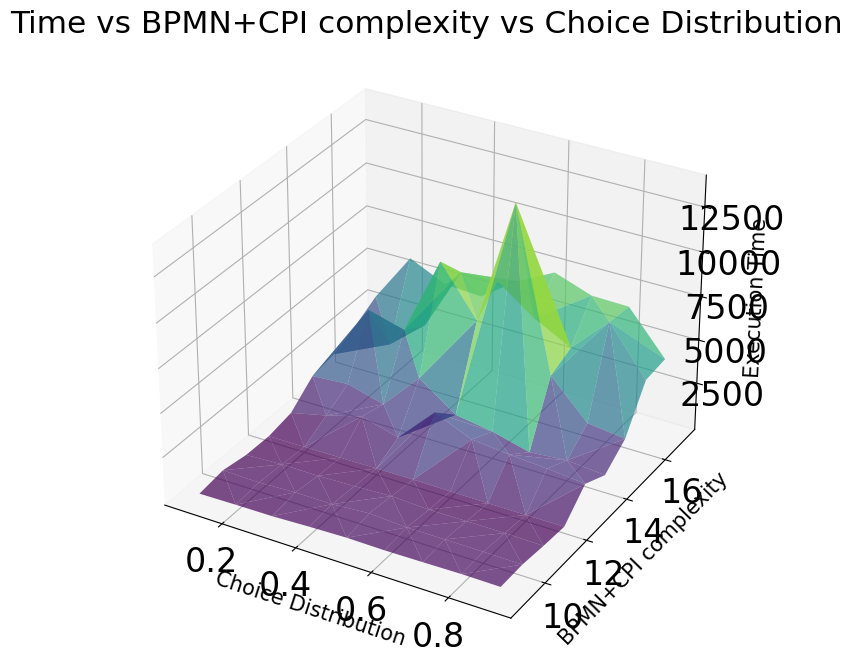

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Compute summed times across all relevant columns
df_times = data[['time_create_execution_tree', 'time_evaluate_cei_execution_tree', 
                 'found_strategy_time', 'build_strategy_time', 
                 'time_explain_strategy', 'strategy_tree_time']].sum(axis=1)

# Extract relevant columns
df = data[['nested', "choice_distribution", "indep", "num_impacts"]].copy()

# Assign the computed strategy tree time
df['strategy_tree_time'] = df_times

# Compute the sum of nested + indep for ordering
df['nested_indep_sum'] = df['nested'] + df['indep']

# Create a 'nested:indep' column
df['nested_indep'] = df['nested'].astype(str) + ":" + df['indep'].astype(str)

# Aggregate duplicate combinations by taking the mean of strategy_tree_time
df_grouped = df.groupby(['num_impacts', 'nested_indep', 'nested_indep_sum', 'choice_distribution'])['strategy_tree_time'].mean().reset_index()

# Sort by sum of nested + indep
df_grouped = df_grouped.sort_values(by="nested_indep_sum")

# Convert 'nested_indep' to a numeric factor while preserving order
df_grouped["nested_indep_code"] = pd.factorize(df_grouped["nested_indep"])[0]
df_grouped["nested_indep_code"] = pd.to_numeric(df_grouped["nested_indep_code"], errors="coerce")

df_grouped = df_grouped[
        (df_grouped["nested_indep_code"] >= 9) 
         # & (df_grouped["nested_indep_code"] <= 13)
    ]

# Set axes
x = df_grouped["choice_distribution"]  # X-axis
y = df_grouped["nested_indep_code"]  # Y-axis (Categorical converted to numeric)
z = df_grouped["strategy_tree_time"]  # Z-axis
c = df_grouped["strategy_tree_time"]  # Color mapping

# Create the figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Create a surface plot using triangulation
ax.plot_trisurf(x, y, z, cmap="viridis", alpha=0.7)
SMALL_SIZE = 15
# Labels
ax.set_xlabel("Choice Distribution", fontsize = SMALL_SIZE)
ax.set_ylabel("BPMN+CPI complexity",  fontsize = SMALL_SIZE)
ax.set_zlabel("Execution Time",  fontsize = SMALL_SIZE)
ax.set_title("Time vs BPMN+CPI complexity vs Choice Distribution",  fontsize = SMALL_SIZE*1.5)
# Font size settings

# Show the plot
# Show the plot
plt.show()


In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

df_times = data[['time_create_execution_tree', 'time_evaluate_cei_execution_tree', 
                 'found_strategy_time', 'build_strategy_time', 
                 'time_explain_strategy', 'strategy_tree_time']].sum(axis=1)

# # Extract relevant columns and assign the summed times correctly
df = data[['nested', "choice_distribution", "indep", "num_impacts", 
           # 'time_create_execution_tree', 'time_evaluate_cei_execution_tree', 
           # 'found_strategy_time', 'build_strategy_time', 
           # 'time_explain_strategy', 'strategy_tree_time'
          ]].copy()

# # Calculate summed strategy tree time
df['strategy_tree_time'] = df_times  # Correctly assign summed times per row

# Create a combined column for nested and indep
df['nested_indep'] = df['nested'].astype(str) + ":" + df['indep'].astype(str)

# Use factorize to convert the 'nested_indep' string into numeric values
df['nested_indep_code'] = pd.factorize(df['nested_indep'])[0]

# Aggregate duplicate combinations by summing their times
df_grouped = df.groupby(['num_impacts', 'nested_indep_code', 'choice_distribution']).strategy_tree_time.mean().reset_index()


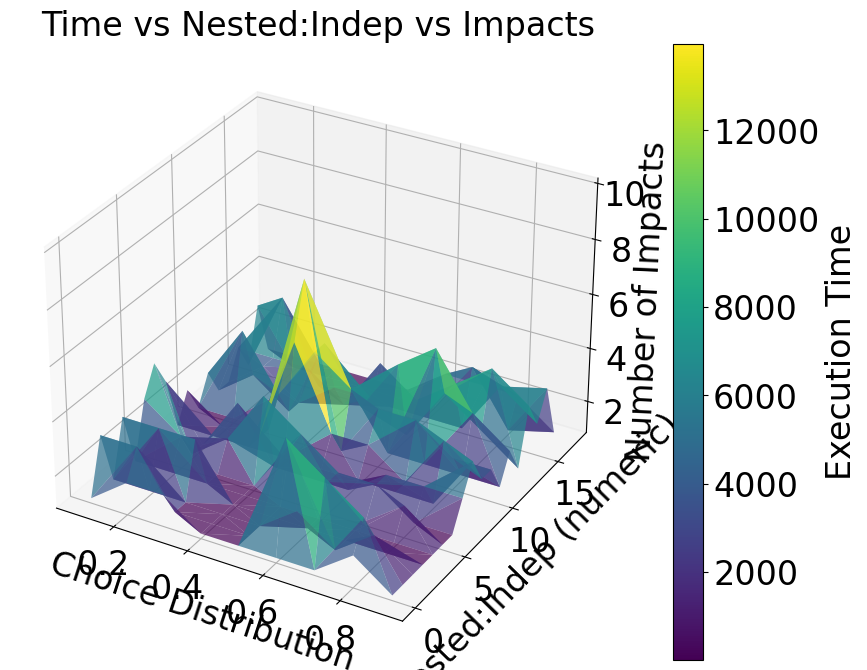

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Set axes
x = df_grouped["choice_distribution"]  # X-axis
y = df_grouped["nested_indep_code"]  # Y-axis (Categorical converted to numeric)
z = df_grouped["num_impacts"]  # Z-axis
c = df_grouped["strategy_tree_time"]  # Color mapping

# Create the figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Create a surface plot using triangulation
ax.plot_trisurf(x, y, z, cmap="viridis", alpha=0.7)

# Labels
ax.set_xlabel("Choice Distribution")
ax.set_ylabel("Nested:Indep (numeric)")
ax.set_zlabel("Number of Impacts")
ax.set_title("Time vs Nested:Indep vs Impacts")

# Color bar for reference
mappable = plt.cm.ScalarMappable(cmap="viridis")
mappable.set_array(c)
fig.colorbar(mappable, ax=ax, label="Execution Time")
plt.show()


# PRISM vs OUR

In the following, we propose the validation against the model checker PRISM

In [ ]:
from pony.orm import Database
import pandas as pd
columnsP = [
    "nested",
    "indep",
    "w",
    "z",
    "num_impacts",
    "choice_distribution",
    "generation_mode",
    
    "duration_interval_min",
    "duration_interval_max",
    "vts",
    "vte",
    "initial_bounds",
    "final_bounds",
    "error"
]
db1 = Database()
db1.bind(provider='sqlite', filename='benchmarks_prism.sqlite', create_db=False) # same as before if not working put full path
# Get data from the DB
dataP = pd.DataFrame(db1.execute("SELECT * FROM experiments"), columns = columnsP)
# Calculate the time in ms
dataP['prism_time'] = (pd.to_datetime(dataP['vte']) - pd.to_datetime(dataP['vts'])).dt.total_seconds() * 1000

In [24]:
dataP

,nested,indep,w,z,num_impacts,choice_distribution,generation_mode,duration_interval_min,duration_interval_max,vts,vte,initial_bounds,final_bounds,error,prism_time
0,1,2,0,1,1,0.1,random,1,10,2025-03-15T11:54:58.439982,2025-03-15T11:55:34.425796,{'impact_1': 5.083605043658887},{'impact_1': 5.083605043658887},No solution found,35985.814
1,1,2,1,1,1,0.1,bagging_divide,1,10,2025-03-15T11:55:34.438693,2025-03-15T11:56:12.159742,{'impact_1': 0.6431429636989907},{'impact_1': 0.6431429636989907},,37721.049
2,1,2,2,1,1,0.1,bagging_remove,1,10,2025-03-15T11:56:12.419070,2025-03-15T11:56:48.167029,{'impact_1': 5.749123073413825},{'impact_1': 5.749123073413825},No solution found,35747.959
3,1,2,3,1,1,0.1,bagging_remove_divide,1,10,2025-03-15T11:56:48.180652,2025-03-15T11:57:23.770970,{'impact_1': 0.5444791815992785},{'impact_1': 0.5444791815992785},No solution found,35590.318
4,1,2,4,1,1,0.1,bagging_remove_reverse,1,10,2025-03-15T11:57:24.081782,2025-03-15T11:57:56.245387,{'impact_1': 0.0},{'impact_1': 0.0},,32163.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14765,2,1,3747,7,10,0.4,bagging_remove_divide,1,10,2025-03-26T14:15:10.849414,2025-03-26T14:18:07.682795,"{'impact_6': 0.41516876513099243, 'impact_4': ...","{'impact_6': 0.3381354981633279, 'impact_4': 0...",,176833.381
14766,2,1,3748,7,10,0.4,bagging_remove_reverse,1,10,2025-03-26T14:18:07.877524,2025-03-26T14:20:50.788035,"{'impact_6': 3.7788239422669596, 'impact_4': 1...","{'impact_6': 3.7788239422669596, 'impact_4': 1...",No solution found,162910.511
14767,2,1,3749,7,10,0.4,bagging_remove_reverse_divide,1,10,2025-03-26T14:20:51.001262,2025-03-26T14:23:20.437577,"{'impact_6': 0.056074814083785014, 'impact_4':...","{'impact_6': 0.056074814083785014, 'impact_4':...",No solution found,149436.315
14768,2,1,3750,7,10,0.5,random,1,10,2025-03-26T14:23:20.678517,2025-03-26T14:30:53.289268,"{'impact_6': 6.881451021238524, 'impact_4': 4....","{'impact_6': 4.7645984121661265, 'impact_4': 3...",,452610.751


Some important statistics between our framework and PRISM

In [25]:
df_times = pd.DataFrame()
df_times['our_find_strategy'] = data[['time_create_execution_tree', 'time_evaluate_cei_execution_tree', 'found_strategy_time']].sum(axis=1)
df_times['prism_find_strategy'] = dataP['prism_time']
df_times.describe()

,our_find_strategy,prism_find_strategy
count,92896.000000,14537.000000
mean,460.256591,46683.521281
std,3231.319918,58378.542586
min,0.000000,4571.945000
25%,7.158000,17965.606000
50%,21.894500,32252.419000
75%,100.417750,49315.876000
max,74343.890000,536322.742000


## Plotting Bar Graph divided by BPMN+CPI complexity

In [26]:
# create a supporting dataframe for our analysis
dfp = dataP[['nested', "indep", 'choice_distribution', "num_impacts", 'generation_mode', 'prism_time']]
# here we consider the time only to find the strategy
dfp['our_time'] =  data[['time_create_execution_tree', 'time_evaluate_cei_execution_tree', 'found_strategy_time']].sum(axis=1) 

/tmp/ipykernel_918776/1559335045.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['our_time'] =  data[['time_create_execution_tree', 'time_evaluate_cei_execution_tree', 'found_strategy_time']].sum(axis=1)


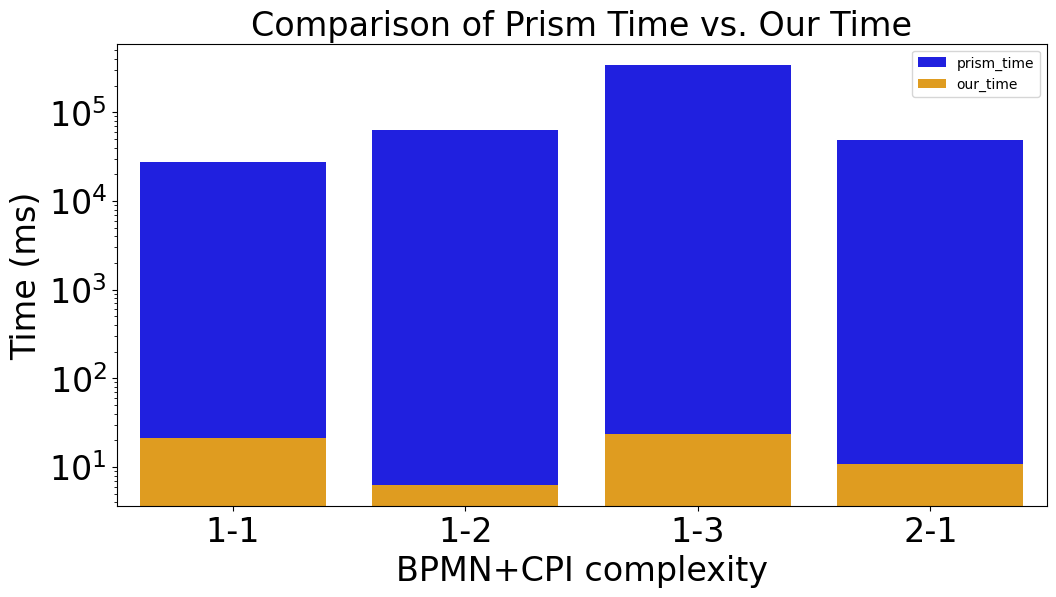

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Group by complexity
grouped_times = dfp.groupby(['nested', "indep"])[['prism_time', 'our_time']].mean().reset_index()

# Print the grouped DataFrame
# print(grouped_times)
grouped_times['group'] = grouped_times[['nested', 'indep']].astype(str).agg('-'.join, axis=1)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='group', y='prism_time', data=grouped_times, color='blue', label='prism_time')
sns.barplot(x='group', y='our_time', data=grouped_times, color='orange', label='our_time')

# plt.xticks(rotation=90)  # Rotate x labels for better visibility
plt.ylabel("Time (ms)")
plt.xlabel("BPMN+CPI complexity")
plt.title("Comparison of Prism Time vs. Our Time")
plt.legend (loc="best", fontsize=10)
plt.yscale('log')
SMALL_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE/1.5)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)
plt.show()